In [558]:
# Implementation of LDA using examples and papers from:
# http://brooksandrew.github.io/simpleblog/articles/latent-dirichlet-allocation-under-the-hood/
# Using the paper http://psiexp.ss.uci.edu/research/papers/SteyversGriffithsLSABookFormatted.pdf 

In [559]:
# Set inline plot for jupyter ipynb
% matplotlib inline 

# Import required modules
# import spacy
# nlp = spacy.load('en')
# from sklearn.preprocessing import OneHotEncoder

# keeping it simple, use only native python structures
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [560]:
# Setting parameters for sampling and LDA
K = 2 # number of topics
alpha = 1 # hyperparameter. single value indicates symmetric dirichlet prior. higher=>scatters document clusters
beta = .001 # hyperparameter
iterations = 1000 # iterations for collapsed gibbs sampling.  This should be a lot higher than 3 in practice.

In [561]:
# Generate a sample corpus
raw_doc = ('eat turkey on turkey day holiday',\
           'i like to eat cake on holiday',\
           'turkey trot race on thanksgiving holiday',\
           'snail race the turtle',\
           'time travel space race',\
           'movie on thanksgiving',\
           'movie at air and space museum is cool movie',\
           'aspiring movie star')

# [Self]-Add stopwords to see the effects LDA, removal should lead to reduction of noise
stopwords = ['is','a','on','at','the','and','to','i']

In [562]:
# Tokenize the documents into words
# tok_doc = [nlp(unicode(doc),'utf-8') for doc in raw_doc]
# can also deal with stopwords here using spacy if required

# lets keep in simple and NOT use spacy for the time being (trouble with word_id)
tokenize = [doc.split(' ') for doc in raw_doc]
# lets remove stop words to remove noise that causes topic changes
tok_doc = [filter(lambda x: x not in stopwords, doc) for doc in tokenize]
num_doc = len(tok_doc) # number of documents

In [563]:
# Create mapping of word <--> Id for fast retrival and hashing index for computation (e.g. {A:1, B:2})
# create id_word and word_id to achieve this
id_word = dict(enumerate(set(itertools.chain.from_iterable(tok_doc)))) #id:word
word_id = {item[1]:item[0] for item in id_word.items()} #word:id
num_word = len(word_id) # store the number of words

# convert the tokens in the document to the token's id representation
for i in range(num_doc):
    tok_doc[i] = [word_id[word] for word in tok_doc[i]]

In [564]:
# Create a structure to store the count of the topic-word frequency.
# This is a matrix of K * W where the rows represent K number of topics and the cols W represent each word
word_topic = np.zeros((K,num_word)) # structure to store the topic-word count, setting all to 0s initially

# create another structure to store the word in each document and it's topic assignment
topic_assign = []
for i in range(num_doc):
    topic_assign.append([0 for row in range(len(tok_doc[i]))]) # setting all the assignment to 0s initially

In [565]:
# As a start, for each word in the documeny, randomly assign it a topic
for d in range(num_doc): # loop for each document
    for w in range(len(tok_doc[d])): # loop for each token word in the document
        # random assign a topic from 1:K to the word
        topic_assign[d][w] = np.random.choice(K,1)[0] # the equivalent of R's sample
        topicId = topic_assign[d][w] # get topic id
        wordId = tok_doc[d][w] # get the word id
        # update the word-topic count
        word_topic[topicId][wordId] = word_topic[topicId][wordId]+1

In [566]:
# create a structure to store the document-topic frequency based on the count of the number of words belonging 
# to a topic in each docmument
# This is a matrix of D * K where the rows represent D number of documents and K number of topics
doc_topic = np.zeros((num_doc,K)) # store the number of words belonging to topic for each document, set to 0s initially
for d in range(num_doc): # loop for each document
    for t in range(K): # loop for each topic
        # count the number of words in the document d assigned to topic t
        doc_topic[d][t] = sum(1 for item in topic_assign[d] if item == t)

perfect convergence, 0 changes


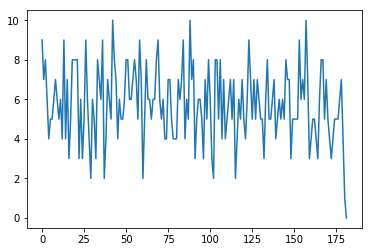

In [567]:
# Using the paper http://psiexp.ss.uci.edu/research/papers/SteyversGriffithsLSABookFormatted.pdf
# apply the gibbs sampling here to find theta and phi
# [Self] - the term collapsed gibbs sampling is also used, need to check whats the different or its just the
#          implmentation is called collasped gibbs sampling.

# Magic of LDA starts!
track_change = [] # [Self] - an array to keep track of the number of changes to topics in each run to see how it converge or diverge

# run based on the number of specified iterations
for i in range(iterations): # number of collasped gibbs sampling iteration to run
    change_update = 0 # tracks the number of changing topic in the iteration
    for d in range(num_doc): # loop for each document
        for w in range(len(tok_doc[d])): # loop for each token word in the document
            # obtain info on current sample word
            curr_topic = topic_assign[d][w] # get the current topic assigned to the word w
            wordId = tok_doc[d][w] # get the current word id for w

            # based on gibbs sampling, we want to decrement the count to exclude the selected word w
            word_topic[curr_topic][wordId] = word_topic[curr_topic][wordId]-1
            doc_topic[d][curr_topic] = doc_topic[d][curr_topic]-1
            
            # to find the probability of the word given to each topic, p_z, we need to solve for the equations of phi and theta
            # obtain the denominator
            phi_denom = word_topic.sum(1) + (num_word*beta) # sum the number of words in each topic for all topic, + W*beta
            theta_denom = doc_topic.sum(0) + (K*alpha) # sum the number of times a topic assign to doc for all doc, +K*alpha
            # calculate the predictive distributions of phi and theta
            phi_dist = (word_topic[:,wordId]+beta) / phi_denom # find the probability of wordId coming for each topic
            theta_dist = (doc_topic[d]+alpha) / theta_denom # find the probability of document producing a certain topic
            
            # calculate the probability of the word given to each topic
            p_z = phi_dist*theta_dist # the result here is a non-normalize probability
            p_z_norm = p_z/p_z.sum() # normalise the reulz
            
            # re-sample a new topic for the word based on the new updated multinomial distribution
            new_topic = np.random.choice(K,1,p=p_z_norm)[0]
            # update back the counts based on the new topic assigned to the word
            topic_assign[d][w] = new_topic
            word_topic[new_topic][wordId] = word_topic[new_topic][wordId]+1
            doc_topic[d][new_topic] = doc_topic[d][new_topic]+1
            
            # print any changes for observation
            if(new_topic != curr_topic):
                change_update = change_update + 1
                # print "document: ",d," token: ",w," from topic: ",curr_topic,'--> ',new_topic
    
    # [self]-check whether is possible to exit out of the loop, set to 0 update for now
    track_change.append(change_update)
    if(change_update == 0):
        print "perfect convergence, 0 changes"
        break
    # [self] - future convergence exit criteria implementation

# plot the number of changes in each iteration to see if convergence occurs
plt.plot(track_change) # [self] - convergence does not occur, though sometimes able to get 0 change.
            

In [568]:
# Assuming theta and phi were solve above (either through some threshiold or iteration)
# print the probability the document coming from K topic
for doc in doc_topic:
    print (doc+alpha)/(doc+alpha).sum(0) # using the generative model of theta

# print the words in each of the topic according in decending order of probability
topicId = 0
for topic in word_topic:
    result = (topic+beta)/(topic+beta).sum(0) # using the generative model of phi
    sorted_idx = np.argsort(result) # sort the results (default ascending)
    print "TopicId:",topicId
    print [[id_word[idx],result[idx]] for idx in reversed(sorted_idx)] # print in descending order
    

[ 0.14285714  0.85714286]
[ 0.16666667  0.83333333]
[ 0.28571429  0.71428571]
[ 0.4  0.6]
[ 0.83333333  0.16666667]
[ 0.5  0.5]
[ 0.875  0.125]
[ 0.8  0.2]
TopicId: 0
[['movie', 0.2497503121098627], ['race', 0.18732833957553058], ['space', 0.12490636704119849], ['museum', 0.062484394506866409], ['air', 0.062484394506866409], ['cool', 0.062484394506866409], ['star', 0.062484394506866409], ['time', 0.062484394506866409], ['aspiring', 0.062484394506866409], ['travel', 0.062484394506866409], ['turtle', 6.2421972534332083e-05], ['like', 6.2421972534332083e-05], ['snail', 6.2421972534332083e-05], ['trot', 6.2421972534332083e-05], ['eat', 6.2421972534332083e-05], ['thanksgiving', 6.2421972534332083e-05], ['day', 6.2421972534332083e-05], ['cake', 6.2421972534332083e-05], ['holiday', 6.2421972534332083e-05], ['turkey', 6.2421972534332083e-05]]
TopicId: 0
[['turkey', 0.18732833957553063], ['holiday', 0.18732833957553063], ['eat', 0.12490636704119852], ['thanksgiving', 0.12490636704119852], ['day